In [3]:
pip install rich

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\Namita Sathish\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [4]:
import pandas as pd
import numpy as np
import re
import joblib
import datetime
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from rich.console import Console
from rich.table import Table
from rich import box

console = Console()

In [5]:
# Load dataset and preprocess
df = pd.read_csv('isear.csv')

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_content'] = df['content'].apply(clean_text)

In [6]:
# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])

In [7]:
# Split and vectorize
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_content'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [8]:
# Train model
model = LogisticRegression(max_iter=500)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=500)

In [9]:
# Evaluate
y_pred = model.predict(X_test_tfidf)
console.print("[bold green]Accuracy:[/bold green]", accuracy_score(y_test, y_pred))
console.print("\n[bold cyan]Classification Report:[/bold cyan]\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.848698099929627

Classification Report:
               precision    recall  f1-score   support

       anger       0.86      0.86      0.86       340
        fear       0.81      0.92      0.86       451
         joy       0.94      0.85      0.89       323
     sadness       0.82      0.74      0.78       307

    accuracy                           0.85      1421
   macro avg       0.86      0.84      0.85      1421
weighted avg       0.85      0.85      0.85      1421

In [10]:
# Mood score map
score_map = {
    'joy': 80,
    'neutral': 0,
    'fear': -60,
    'anger': -80,
    'sadness': -70,
    'disgust': -60,
    'shame': -90,
    'guilt': -50
}

In [11]:
def predict_mood_score(text):
    cleaned = clean_text(text)
    vec = vectorizer.transform([cleaned])
    pred_label = model.predict(vec)[0]
    pred_emotion = le.inverse_transform([pred_label])[0]
    mood_score = score_map.get(pred_emotion, 0)
    return pred_emotion, mood_score

# Save models
joblib.dump(model, 'mood_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(le, 'label_encoder.pkl')

journal_data = defaultdict(list)


In [12]:
def explain_mood_score(score):
    if score >= 50:
        return "You seem to be in a positive mood."
    elif 0 <= score < 50:
        return "Your mood is neutral to slightly positive."
    else:
        return "Your mood appears low. Consider self-care or seeking support."

In [13]:
def add_journal_entry(entry_text):
    timestamp = datetime.datetime.now()
    date_str = timestamp.date().isoformat()
    emotion, score = predict_mood_score(entry_text)
    journal_data[date_str].append({'timestamp': timestamp, 'text': entry_text, 'emotion': emotion, 'score': score})

    scores_today = [e['score'] for e in journal_data[date_str]]
    avg_score = sum(scores_today) / len(scores_today)

    explanation = explain_mood_score(avg_score)

    console.print(f"\n[bold yellow]Entry added.[/bold yellow] Emotion: [green]{emotion}[/green], Mood Score: [bold]{score}[/bold]")
    console.print(f"Today's average mood score: [bold]{avg_score:.2f}[/bold] — {explanation}\n")

    check_mood_alert()

In [14]:

def check_mood_alert(threshold=-40, days=3):
    dates = sorted(journal_data.keys())[-days:]
    if len(dates) < days:
        return

    avg_scores = []
    for d in dates:
        scores = [e['score'] for e in journal_data[d]]
        avg_scores.append(sum(scores)/len(scores))

    if all(s < threshold for s in avg_scores):
        console.print("[bold red]!!! ALERT:[/bold red] You've had consistently low mood scores for the past few days.")
        print_recommended_resources()

In [15]:
def print_recommended_resources():
    resources = [
        {"name": "National Helpline", "link": "tel:123-456-7890"},
        {"name": "Meditation App", "link": "https://www.headspace.com"},
        {"name": "Self-Help Articles", "link": "https://www.psychologytoday.com/us/blog"},
        {"name": "Counseling Center", "link": "https://www.betterhelp.com"}
    ]
    table = Table(title="Recommended Resources", box=box.SIMPLE)
    table.add_column("Name", style="cyan")
    table.add_column("Link", style="magenta")
    for r in resources:
        table.add_row(r['name'], r['link'])
    console.print(table)

In [16]:
def plot_mood_trend():
    if not journal_data:
        console.print("[bold red]No journal entries to plot.[/bold red]")
        return

    all_entries = []
    for day_entries in journal_data.values():
        all_entries.extend(day_entries)

    all_entries.sort(key=lambda x: x['timestamp'])
    times = [e['timestamp'] for e in all_entries]
    scores = [e['score'] for e in all_entries]

    plt.figure(figsize=(10, 5))
    plt.plot(times, scores, marker='o', linestyle='-', color='blue')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("Mood Score per Journal Entry")
    plt.xlabel("Timestamp")
    plt.ylabel("Mood Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [17]:
def view_entries():
    table = Table(title="Journal Entries", box=box.MINIMAL_DOUBLE_HEAD)
    table.add_column("Date & Time", style="dim")
    table.add_column("Emotion", style="green")
    table.add_column("Mood Score", justify="right")
    table.add_column("Entry Snippet", style="cyan")

    for day_entries in journal_data.values():
        for entry in day_entries:
            snippet = entry['text'][:50] + ('...' if len(entry['text']) > 50 else '')
            table.add_row(str(entry['timestamp']), entry['emotion'], str(entry['score']), snippet)
    console.print(table)

Entry added. Emotion: joy, Mood Score: 80

Today's average mood score: 8.33 — Your mood is neutral to slightly positive.

Entry added. Emotion: fear, Mood Score: -60

Today's average mood score: -1.43 — Your mood appears low. Consider self-care or seeking support.

Entry added. Emotion: sadness, Mood Score: -70

Today's average mood score: -10.00 — Your mood appears low. Consider self-care or seeking support.

Entry added. Emotion: fear, Mood Score: -60

Today's average mood score: -15.56 — Your mood appears low. Consider self-care or seeking support.

Entry added. Emotion: fear, Mood Score: -60

Today's average mood score: -20.00 — Your mood appears low. Consider self-care or seeking support.

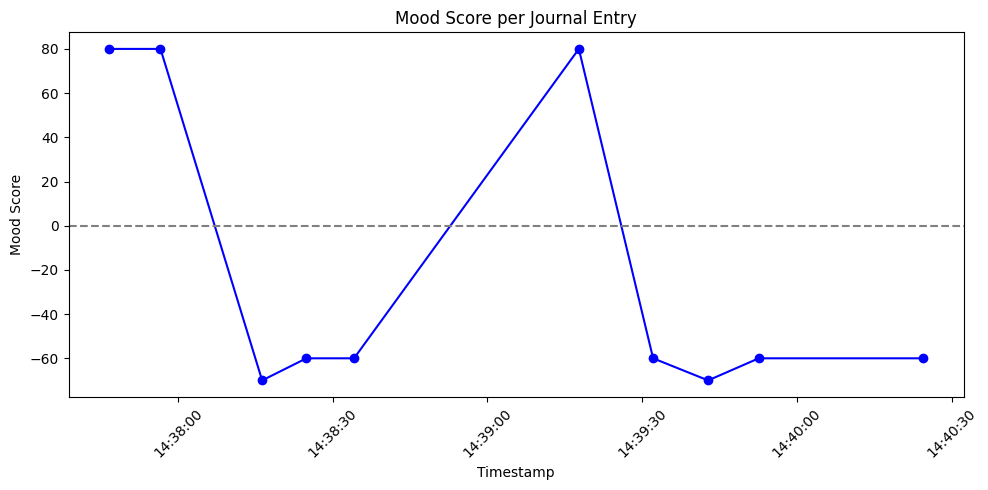

                                               Journal Entries                                               
                             ╷         ╷            ╷                                                        
  Date & Time                │ Emotion │ Mood Score │ Entry Snippet                                          
 ════════════════════════════╪═════════╪════════════╪═══════════════════════════════════════════════════════ 
  2025-06-07 14:37:46.655074 │ joy     │         80 │ The sunrise painted the sky in hues of pink and go...  
  2025-06-07 14:37:56.598152 │ joy     │         80 │ The sunrise painted the sky in hues of pink and go...  
  2025-06-07 14:38:16.308342 │ sadness │        -70 │ I found an old photo of my grandparents while clea...  
  2025-06-07 14:38:24.890974 │ fear    │        -60 │ The rain tapped gently against the window, a sooth...  
  2025-06-07 14:38:34.131588 │ fear    │        -60 │ It’s 2 AM, and my mind won’t shut off—what if I fa...  
  2025-06-07 14:39:17.725859 │ joy     │         80 │ The sunrise painted the sky in hues of pink and go...  
  2025-06-07 14:39:32.125895 │ fear    │        -60 │ My laptop froze again, erasing an hour’s worth of ...  
  2025-06-07 14:39:42.797222 │ sadness │        -70 │ I found an old photo of my grandparents while clea...  
  2025-06-07 14:39:52.615699 │ fear    │        -60 │ The rain tapped gently against the window, a sooth...  
  2025-06-07 14:40:24.457755 │ fear    │        -60 │ It’s 2 AM, and my mind won’t shut off—what if I fa...  
                             ╵         ╵            ╵

In [20]:
# Start journal loop
while True:
    entry = input("Write your journal entry (or type 'exit', 'plot', or 'view'):\n")
    if entry.lower() == 'exit':
        break
    elif entry.lower() == 'plot':
        plot_mood_trend()
        continue
    elif entry.lower() == 'view':
        view_entries()
        continue
    add_journal_entry(entry)